In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
warnings.simplefilter('ignore')
%matplotlib inline

# Introduction  

There is an seemingly never ending supply of financial data, and the Quandl package offers relatively easy access to not only the raw prices but also more advanced indicators. I am only going to focus on the adjusted closing prices of two companies in the same industry: General Motors and Tesla.

In [2]:
# quandl for financial data
import quandl
quandl.ApiConfig.api_key = 'TuxigqPxhP2_J8YE7ThL'
# Retrieve TSLA data from Quandl
tesla = quandl.get('WIKI/TSLA')
# Retrieve the GM data from Quandl
gm = quandl.get('WIKI/GM')
gm.head(5)

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2010-11-18,35.00,35.99,33.89,34.19,457044300.0,0.0,1.0,29.988317,30.836558,29.037259,29.294302,457044300.0
2010-11-19,34.15,34.50,33.11,34.26,107842000.0,0.0,1.0,29.260029,29.559912,28.368948,29.354278,107842000.0
2010-11-22,34.20,34.48,33.81,34.08,36650600.0,0.0,1.0,29.302870,29.542776,28.968714,29.200053,36650600.0
2010-11-23,33.95,33.99,33.19,33.25,31170200.0,0.0,1.0,29.088668,29.122940,28.437493,28.488901,31170200.0
2010-11-24,33.73,33.80,33.22,33.48,26138000.0,0.0,1.0,28.900170,28.960146,28.463197,28.685967,26138000.0


Tesla is quite an interesting company, for a variety of reasons: it is the first successful automobile start-up in the United States in over 110 years, it surpassed General Motors for market cap at time in 2017 and, oh, Elon Musk. General Motors, on the other hand, was founded in 1908, currently produces and markets over 30 different models, filed for Chapter 11 bankruptcy on June 1, 2009 and received over 10 billion US dollars in bailout money. Tesla currently manufactures 5 different automobiles.  

**Plot the time series, along with any logical or necessary differences to get a stationary dataset**

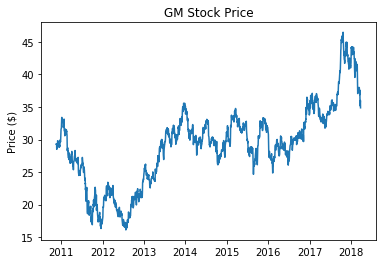

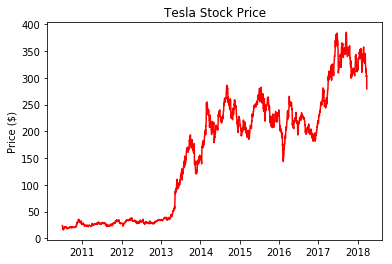

In [9]:
# The adjusted close accounts for stock splits, so that is what we should graph
plt.plot(gm.index, gm['Adj. Close'])
plt.title('GM Stock Price')
plt.ylabel('Price ($)');
plt.show()
plt.plot(tesla.index, tesla['Adj. Close'], 'r')
plt.title('Tesla Stock Price')
plt.ylabel('Price ($)');
plt.show();

In [3]:
gm['Daily Returns'] = gm['Adj. Close'] - gm['Adj. Close'].shift()
tesla['Daily Returns'] = tesla['Adj. Close'] - tesla['Adj. Close'].shift()

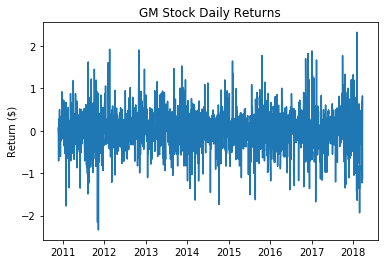

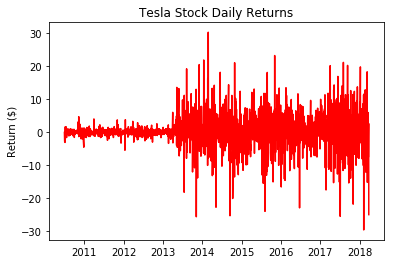

In [16]:
plt.plot(gm.index, gm['Daily Returns'])
plt.title('GM Stock Daily Returns')
plt.ylabel('Return ($)');
plt.show()
plt.plot(tesla.index, tesla['Daily Returns'], 'r')
plt.title('Tesla Stock Daily Returns')
plt.ylabel('Return ($)');
plt.show();

**Generate and interpret a PACF for the time series (and/or its differences)**

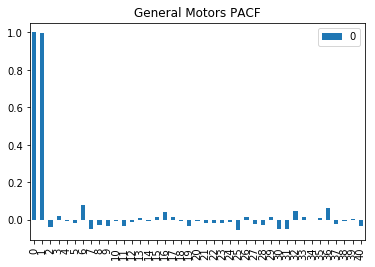

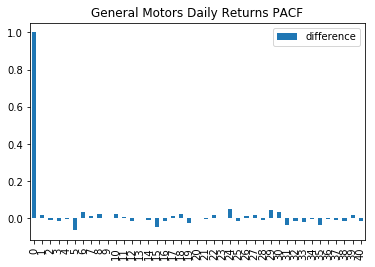

In [24]:
from statsmodels.tsa.stattools import pacf
x_acf = pd.DataFrame(pacf(gm['Adj. Close']))
x_acf.plot(kind='bar')
plt.title("General Motors PACF")
plt.show()

x_acf = pd.DataFrame(pacf(gm['Daily Returns'][1:]))
x_acf.plot(kind='bar')
plt.title("General Motors Daily Returns PACF")
plt.legend(['difference'])
plt.show()

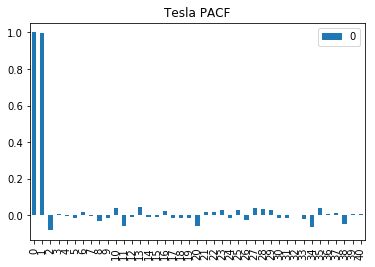

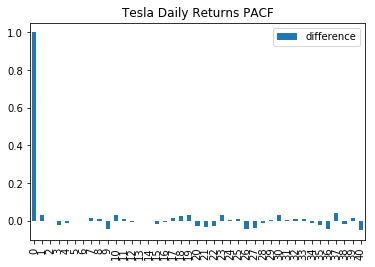

In [25]:
x_acf = pd.DataFrame(pacf(tesla['Adj. Close']))
x_acf.plot(kind='bar')
plt.title("Tesla PACF")
plt.show()

x_acf = pd.DataFrame(pacf(tesla['Daily Returns'][1:]))
x_acf.plot(kind='bar')
plt.title("Tesla Daily Returns PACF")
plt.legend(['difference'])
plt.show()

So the daily returns both appear to be stationary.

**Generate 5 ARIMA specifications and evaluate their efficacy at modeling your data**

In [52]:
from statsmodels.tsa.arima_model import ARIMA

'''
p: The number of lag observations included in the model, also called the lag order.
d: The number of times that the raw observations are differenced, 
    also called the degree of differencing.
q: The size of the moving average window, also called the order of moving average.
'''

def build_arima(data, p,d,q):
    model = ARIMA(data, order=(p,d,q))
    model_fit = model.fit()
    return (model_fit.llf, model_fit.aic)

In [53]:
results = []

p_values = [0,1,2,3,4]
d_values = [0,1] #range(0,2)
q_values = [0,1]

for p in p_values:
    for q in q_values:
        for d in d_values:
            #print("{},{},{}".format(p,d,q))
            ll, aic = build_arima(gm['Adj. Close'].values, p, d, q)
            results.append((p,d,q,ll,aic))
            
results = pd.DataFrame(results, columns=['p','d','q','log_likelihood','aic'])

In [54]:
results

,p,d,q,log_likelihood,aic
0,0,0,0,-5965.235022,11934.470044
1,0,1,0,-1295.981937,2595.963874
2,0,0,1,-4796.974953,9599.949906
3,0,1,1,-1295.617219,2597.234437
4,1,0,0,-1297.445906,2600.891812
5,1,1,0,-1295.624415,2597.248830
6,1,0,1,-1297.017140,2602.034279
7,1,1,1,-1295.587819,2599.175638
8,2,0,0,-1297.024168,2602.048336
9,2,1,0,-1295.525412,2599.050824


In [55]:
results = []

p_values = [0,1,2,3,4]
d_values = [0,1] #range(0,2)
q_values = [0,1]

for p in p_values:
    for q in q_values:
        for d in d_values:
            #print("{},{},{}".format(p,d,q))
            ll, aic = build_arima(tesla['Adj. Close'].values, p, d, q)
            results.append((p,d,q,ll,aic))
            
results = pd.DataFrame(results, columns=['p','d','q','log_likelihood','aic'])
results

,p,d,q,log_likelihood,aic
0,0,0,0,-11944.610753,23893.221505
1,0,1,0,-5887.349349,11778.698697
2,0,0,1,-10650.046047,21306.092094
3,0,1,1,-5886.415016,11778.830032
4,1,0,0,-5893.819939,11793.639877
5,1,1,0,-5886.415380,11778.830760
6,1,0,1,-5892.806905,11793.613810
7,1,1,1,-5886.414604,11780.829207
8,2,0,0,-5892.804572,11793.609144
9,2,1,0,-5886.413376,11780.826752


**Finally choose one specification and make the case for that as a logical model for your dataset.**  

Given these hyperparameters, and only using AIC and log-likelihood values I would go with (3,1,1) for an ARIMA model to forecast GM prices, and (4,1,1) for Tesla prices. However, I do not expect these models to accurately forecast GM or Tesla prices, so I will use Prophet.

In [9]:
# Need the date field for Prophet
gm.reset_index(inplace=True)
tesla.reset_index(inplace=True)

In [11]:
import fbprophet
# Prophet requires columns ds (Date) and y (value)
gm2 = gm.rename(columns={'Date': 'ds', 'Adj. Close': 'y'})
# Make the prophet model and fit on the data
gm_prophet = fbprophet.Prophet(changepoint_prior_scale=0.15)
gm_prophet.fit(gm2)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


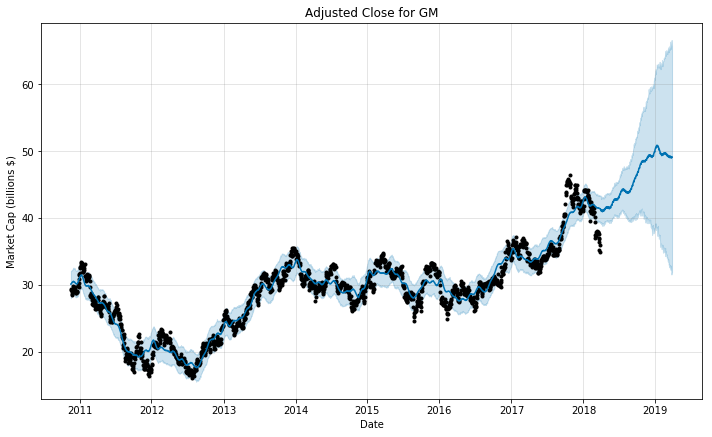

In [24]:
# Make a future dataframe for 2 years
gm_forecast = gm_prophet.make_future_dataframe(periods=365, freq='D')
# Make predictions
gm_forecast = gm_prophet.predict(gm_forecast)

gm_prophet.plot(gm_forecast, xlabel = 'Date', ylabel = 'Market Cap (billions $)')
plt.title('Adjusted Close for GM');

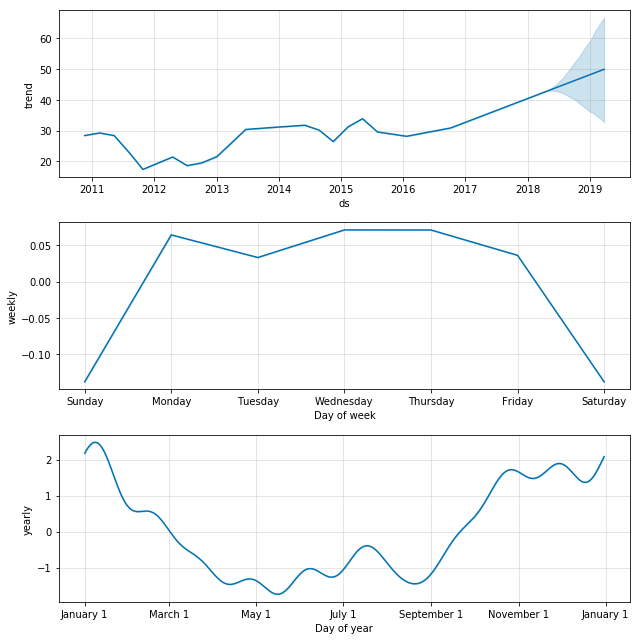

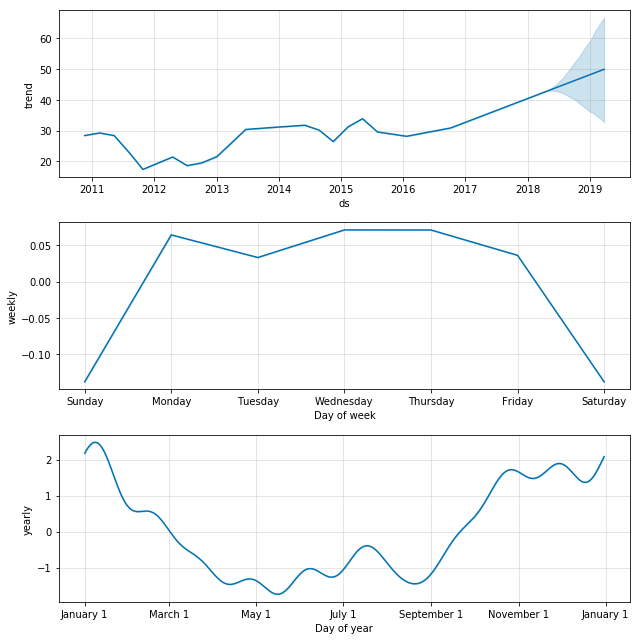

In [25]:
# Plot the trends and patterns
gm_prophet.plot_components(gm_forecast)

# SARIMA  

The Seasonal Autoregressive Integrated Moving Average, or SARIMA, model is an approach for modeling univariate time series data that may contain trend and seasonal components. Financial data almost certainly contains trends and or seasonal components, so this type of model seems appropriate here.

In [20]:
# grid search sarima hyperparameters
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
 
# one-step sarima forecast
def sarima_forecast(history, config):
    order, sorder, trend = config
    # define model
    model = SARIMAX(history, order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
    # fit model
    model_fit = model.fit(disp=False)
    # make one step forecast
    yhat = model_fit.predict(len(history), len(history))
    return yhat[0]

# root mean squared error or rmse
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = sarima_forecast(history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_rmse(test, predictions)
    return error

# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
    result = None
    # convert config to a key
    key = str(cfg)
    # show all warnings and fail on exception if debugging
    if debug:
        result = walk_forward_validation(data, n_test, cfg)
    else:
        # one failure during model validation suggests an unstable config
        try:
            # never show warnings when grid searching, too noisy
            with catch_warnings():
                filterwarnings("ignore")
                result = walk_forward_validation(data, n_test, cfg)
        except:
            error = None
    # check for an interesting result
    if result is not None:
        print(' > Model[%s] %.3f' % (key, result))
    return (key, result)

# grid search configs
def grid_search(data, cfg_list, n_test, parallel=True):
    scores = None
    if parallel:
        # execute configs in parallel
        executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
        tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
        scores = executor(tasks)
    else:
        scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
    # remove empty results
    scores = [r for r in scores if r[1] != None]
    # sort configs by error, asc
    scores.sort(key=lambda tup: tup[1])
    return scores

# create a set of sarima configs to try
def sarima_configs(seasonal=[0]):
    models = list()
    # define config lists
    p_params = [0]
    d_params = [0]
    q_params = [0]
    t_params = ['n']
    P_params = [0, 1]
    D_params = [0, 1]
    Q_params = [0, 1]
    m_params = seasonal
    # create config instances
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for t in t_params:
                    for P in P_params:
                        for D in D_params:
                            for Q in Q_params:
                                for m in m_params:
                                    cfg = [(p,d,q), (P,D,Q,m), t]
                                    models.append(cfg)
    return models

In [21]:
# define dataset
data = tesla['Adj. Close'].values
print(data.shape)
# data split
n_test = round(0.4*len(tesla))
# model configs
cfg_list = sarima_configs()
# grid search
scores = grid_search(data, cfg_list, n_test)
print('done')
# list top 3 configs
for cfg, error in scores[:3]:
    print(cfg, error)

(1949,)
 > Model[[(0, 0, 0), (0, 0, 0, 0), 'n']] 265.343
 > Model[[(0, 0, 0), (1, 0, 1, 0), 'n']] 6.251
 > Model[[(0, 0, 0), (1, 0, 0, 0), 'n']] 6.252
 > Model[[(0, 0, 0), (0, 0, 1, 0), 'n']] 134.616
done
[(0, 0, 0), (1, 0, 1, 0), 'n'] 6.251259770316096
[(0, 0, 0), (1, 0, 0, 0), 'n'] 6.251646213036199
[(0, 0, 0), (0, 0, 1, 0), 'n'] 134.61554420597759


# Conclusion  

A SARIMA model, with no trend and hyperparameters (0, 0, 0) (1, 0, 1, 0) produce the most accurate forecasts of our 3 different model types. However, the most recent price of GM's stock is about $38 a share, so a RMSE of 6.251 is a little over 15.6% off.  

Prophet offers a lot of features right out of the box; here I particularly utilize Prophet for visualizing seasonality/trends as well as forecasting.